In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.experimental import enable_iterative_imputer
sklearn.set_config(transform_output='pandas')

FILE_PATH ="NHANES_hypertension(1).pkl"
IT_IMP_SUBSET = 2000


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt



# Assignment 3: Handling missing data

In this assignment, you will explore different methods for handling missing values in the development of prediction models. You will use a data set based on the National Health and Nutrition Examination Survey (NHANES) run by the Centers for Disease Control and Prevention (CDC) in the USA: https://www.cdc.gov/nchs/nhanes/index.htm.

**NOTE: Due to a request from the mid-course meeting, the template is now ground-truth for the assignment. In the case of differences between Canvas and the template, follow the notebook template**

## Goal

* Your goal is to predict hypertension (high blood pressure) from a number of subject covariates.
* You will compare impute-then-regress classifiers to methods that handle missing values natively.

## Data

The NHANES survey is possible to download from the CDC but is spread over 100s of CSV files. For your convenience, we have compiled a .pkl file with a dataframe for this assignment. We cannot share it publicly on the web so instead...

* For this assignment, you will need to download a [.pkl data file](https://chalmers.instructure.com/files/3817584/download?download_frd=1) from Canvas
* Place the file with the name ```NHANES_hypertension.pkl``` in the same directory as this notebook
* The covariates are described in the file [```NHANES_hypertension.codes.txt```](https://chalmers.instructure.com/files/3817583/download?download_frd=1)

In [33]:
D_full = pd.read_pickle(FILE_PATH)
print(D_full)

              SEQN       YEAR  RIDAGEYR RIAGENDR SMQ020 SMD680  SMD415  \
SEQN                                                                     
2.0            2.0  1999-2000      77.0      1.0    2.0    2.0     NaN   
3.0            3.0  1999-2000      10.0      2.0    NaN    NaN     1.0   
5.0            5.0  1999-2000      49.0      1.0    1.0    1.0     NaN   
6.0            6.0  1999-2000      19.0      2.0    NaN    2.0     NaN   
7.0            7.0  1999-2000      59.0      2.0    1.0    2.0     NaN   
...            ...        ...       ...      ...    ...    ...     ...   
102952.0  102952.0  2017-2018      70.0      2.0    2.0    2.0     0.0   
102953.0  102953.0  2017-2018      42.0      1.0    1.0    2.0     0.0   
102954.0  102954.0  2017-2018      41.0      2.0    2.0    2.0     0.0   
102955.0  102955.0  2017-2018      14.0      2.0    NaN    2.0     2.0   
102956.0  102956.0  2017-2018      38.0      1.0    1.0    1.0     1.0   

          SMD415A PAD020 PAD200  ... 

## Problem 1 — Exploration & imputation

### Data exploration & setup

* The columns 'SEQN' and 'YEAR' represent the subject ID and year of survey respectively. These should *not* be used as input for prediction.
* The outcome column $Y$ is called 'HYPERT'
* The columns 'BPXSY1', 'BPXDI1', 'BPXOSY1', 'BPXODI1' all measure the blood pressure and are used to compute the outcome. These should *not* be used as input for prediction.


1. Report the frequency of missing values in each input column

In [34]:
#Frequency of Nan for each column

df = pd.DataFrame(D_full)
print(df.isna().sum())

SEQN            0
YEAR            0
RIDAGEYR        0
RIAGENDR        0
SMQ020      20964
SMD680      45915
SMD415      39750
SMD415A     39750
PAD020      45184
PAD200      45186
PAD320      45192
DIQ010         46
BMXWT         736
BMXHT         726
BMXBMI        912
BMXWAIST     2513
OHAROCDT    55352
OHAROCGP    59385
OHARNF      42305
ALQ120Q     35253
BPQ020      14744
DRXTTFAT     3857
DRXTSFAT     3857
BPXSY1          0
BPXDI1          0
LBXSAL      11152
LBXSGL      11156
LBXSCH      11161
LBXSUA      11168
LBXSKSI     11164
MCQ160C     37027
MCQ080      38741
OCQ180      41125
OCQ380      45402
DBD100      28780
OCD180      66291
DR1TTFAT    16983
DR1TSFAT    16983
INDFMMPI    32138
PAD645      58501
PAD660      58820
PAD675      53819
SMD460      48521
SMDANY      43082
BMXHIP      63218
ALQ121      64664
MCQ366C     63506
BPXOSY1     62975
BPXODI1     62975
HYPERT          0
dtype: int64


In [4]:
#check :count frequency of Nan in column SMQ020 is correct
D_full['SMQ020'].isna().sum()

20964

2. Remove columns with more than 50% missingness and report which columns you removed and which remain

In [5]:
# percentage of null in every column
percentage_null = df.isnull().sum()/df.shape[0]*100

# Below code gives list of columns having more than 50% null
col_to_drop = percentage_null[percentage_null>50].keys()


output_df = df.drop(col_to_drop, axis=1)

print("Column removed: ", col_to_drop)
print("Remaining columns: ", output_df.columns)

Column removed:  Index(['SMD680', 'SMD415', 'SMD415A', 'PAD020', 'PAD200', 'PAD320', 'OHAROCDT',
       'OHAROCGP', 'OHARNF', 'ALQ120Q', 'MCQ160C', 'MCQ080', 'OCQ180',
       'OCQ380', 'OCD180', 'PAD645', 'PAD660', 'PAD675', 'SMD460', 'SMDANY',
       'BMXHIP', 'ALQ121', 'MCQ366C', 'BPXOSY1', 'BPXODI1'],
      dtype='object')
Remaining columns:  Index(['SEQN', 'YEAR', 'RIDAGEYR', 'RIAGENDR', 'SMQ020', 'DIQ010', 'BMXWT',
       'BMXHT', 'BMXBMI', 'BMXWAIST', 'BPQ020', 'DRXTTFAT', 'DRXTSFAT',
       'BPXSY1', 'BPXDI1', 'LBXSAL', 'LBXSGL', 'LBXSCH', 'LBXSUA', 'LBXSKSI',
       'DBD100', 'DR1TTFAT', 'DR1TSFAT', 'INDFMMPI', 'HYPERT'],
      dtype='object')


* Variable types can be found in the property ```dtypes``` of the dataframe. Categorical variables have the type 'category'

3. Perform one-hot encoding of categorical variables such that missing values are encoded as a separate category. For example, if a binary variable ```Test``` has values 0, 1 and missing values NaN, the categories should be ```Test_0```, ```Test_1``` and ```Test_NaN``` (although, the names are up to you)
4. Split your data into a training portion (80%) and a test portion (20%) with random_state=0
5. Fit a standard scaler to the numeric features in the training portion and apply that to both training and test sets

In [35]:
# list of columns to exclude for project requirements
columns_to_exclude = ['SEQN', 'YEAR', 'BPXSY1', 'BPXDI1', 'BPXOSY1', 'BPXODI1']

# drop the excluded columns
output_df = df.drop(columns=columns_to_exclude, axis=1)

#checking each colum type from output_df
print(output_df.dtypes)

RIDAGEYR     float64
RIAGENDR    category
SMQ020      category
SMD680      category
SMD415       float64
SMD415A      float64
PAD020      category
PAD200      category
PAD320      category
DIQ010      category
BMXWT        float64
BMXHT        float64
BMXBMI       float64
BMXWAIST     float64
OHAROCDT    category
OHAROCGP    category
OHARNF      category
ALQ120Q      float64
BPQ020      category
DRXTTFAT     float64
DRXTSFAT     float64
LBXSAL       float64
LBXSGL       float64
LBXSCH       float64
LBXSUA       float64
LBXSKSI      float64
MCQ160C     category
MCQ080      category
OCQ180       float64
OCQ380      category
DBD100      category
OCD180       float64
DR1TTFAT     float64
DR1TSFAT     float64
INDFMMPI     float64
PAD645       float64
PAD660       float64
PAD675       float64
SMD460      category
SMDANY      category
BMXHIP       float64
ALQ121      category
MCQ366C     category
HYPERT         int64
dtype: object


In [7]:
# check if dropped the correct columns
print("df with excluded columns: ")
output_df.columns

df with excluded columns: 


Index(['RIDAGEYR', 'RIAGENDR', 'SMQ020', 'SMD680', 'SMD415', 'SMD415A',
       'PAD020', 'PAD200', 'PAD320', 'DIQ010', 'BMXWT', 'BMXHT', 'BMXBMI',
       'BMXWAIST', 'OHAROCDT', 'OHAROCGP', 'OHARNF', 'ALQ120Q', 'BPQ020',
       'DRXTTFAT', 'DRXTSFAT', 'LBXSAL', 'LBXSGL', 'LBXSCH', 'LBXSUA',
       'LBXSKSI', 'MCQ160C', 'MCQ080', 'OCQ180', 'OCQ380', 'DBD100', 'OCD180',
       'DR1TTFAT', 'DR1TSFAT', 'INDFMMPI', 'PAD645', 'PAD660', 'PAD675',
       'SMD460', 'SMDANY', 'BMXHIP', 'ALQ121', 'MCQ366C', 'HYPERT'],
      dtype='object')

In [8]:
#print only categorical columns
categorical_cols = output_df.select_dtypes(include=['category']).columns
categorical_cols

Index(['RIAGENDR', 'SMQ020', 'SMD680', 'PAD020', 'PAD200', 'PAD320', 'DIQ010',
       'OHAROCDT', 'OHAROCGP', 'OHARNF', 'BPQ020', 'MCQ160C', 'MCQ080',
       'OCQ380', 'DBD100', 'SMD460', 'SMDANY', 'ALQ121', 'MCQ366C'],
      dtype='object')

In [9]:
# perform one-hot encoding of categorical columns, ensuring NaN is treated as a separate category
encoded_output = pd.get_dummies(output_df, columns=categorical_cols, dummy_na=True)
print("One-hot encoded dataframe:\n",encoded_output.head())

One-hot encoded dataframe:
       RIDAGEYR  SMD415  SMD415A  BMXWT  BMXHT  BMXBMI  BMXWAIST  ALQ120Q  \
SEQN                                                                       
2.0       77.0     NaN      NaN   75.4  174.0   24.90      98.0     24.0   
3.0       10.0     1.0      1.0   32.9  136.6   17.63      64.7      NaN   
5.0       49.0     NaN      NaN   92.5  178.3   29.10      99.9      4.0   
6.0       19.0     NaN      NaN   59.2  162.0   22.56      81.6      NaN   
7.0       59.0     NaN      NaN   78.0  162.9   29.39      90.7      NaN   

      DRXTTFAT  DRXTSFAT  ...  ALQ121_5.0  ALQ121_6.0  ALQ121_7.0  ALQ121_8.0  \
SEQN                      ...                                                   
2.0      71.95     24.34  ...       False       False       False       False   
3.0      49.94     15.61  ...       False       False       False       False   
5.0     114.52     36.00  ...       False       False       False       False   
6.0      25.15      7.78  ...     

In [10]:
#I assumed HYPERT is the target
X = encoded_output.drop(columns=['HYPERT'])  # Drop the target column 'HYPERT'
y = encoded_output['HYPERT']

#splitted dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (55294, 103)
Test set size: (13824, 103)


In the first step i explored the dataset and looked for missing values,then I removed columns with more than 50% missing data to ensure the analysis used only useful information. I excluded also columns like SEQN( subject ID) and YEAR (survey year), which were not useful for predicting hypertension. For categorical variables, I applied one hot encoding, ensuring that missing values were treated as separate category(for instance Variablename_nan). The target variable such as HYPERT was kept separated from the features since it represnts hypertension status. After preparing the features and excluding the target variable, I split the data into training (80%) and testing (20%) ensuring a fair valuation of the model's performance.

### Imputation

6. Fit a constant imputer for numeric (non-categorical) input variables on the training set using the variable *median* as constant. Categorical variables should not be imputed since they are handled by the one-hot encoding. Impute missing values both in the training and test sets.

In [11]:
# Print encode output to see dataset
print(encoded_output.head())

      RIDAGEYR  SMD415  SMD415A  BMXWT  BMXHT  BMXBMI  BMXWAIST  ALQ120Q  \
SEQN                                                                       
2.0       77.0     NaN      NaN   75.4  174.0   24.90      98.0     24.0   
3.0       10.0     1.0      1.0   32.9  136.6   17.63      64.7      NaN   
5.0       49.0     NaN      NaN   92.5  178.3   29.10      99.9      4.0   
6.0       19.0     NaN      NaN   59.2  162.0   22.56      81.6      NaN   
7.0       59.0     NaN      NaN   78.0  162.9   29.39      90.7      NaN   

      DRXTTFAT  DRXTSFAT  ...  ALQ121_5.0  ALQ121_6.0  ALQ121_7.0  ALQ121_8.0  \
SEQN                      ...                                                   
2.0      71.95     24.34  ...       False       False       False       False   
3.0      49.94     15.61  ...       False       False       False       False   
5.0     114.52     36.00  ...       False       False       False       False   
6.0      25.15      7.78  ...       False       False       Fa

In [12]:
# selected only numerical (non-categorical) columns from the encoded dataset
numerical_cols = encoded_output.select_dtypes(exclude=['category']).columns

#created an imputer that replaces missing values with the median of each column
imputer = SimpleImputer(strategy='median')

#fitted the imputer on the training set and transform the training set
encoded_output_train = encoded_output.loc[X_train.index]  # Get the training data
encoded_output_test = encoded_output.loc[X_test.index]  # Get the test data

# fitted the imputer on the training set only (for the numeric columns)
encoded_output_train[numerical_cols] = imputer.fit_transform(encoded_output_train[numerical_cols])

#apply the same imputation on the test set (use the fitted imputer)
encoded_output_test[numerical_cols] = imputer.transform(encoded_output_test[numerical_cols])

#print the first few rows of the imputed training and test sets to confirm
print("Training set after imputation:\n", encoded_output_train.head())
print("Test set after imputation:\n", encoded_output_test.head())


Training set after imputation:
          RIDAGEYR  SMD415  SMD415A  BMXWT  BMXHT  BMXBMI  BMXWAIST  ALQ120Q  \
SEQN                                                                          
75252.0      43.0     0.0      0.0   95.0  176.4   30.50     111.4      1.0   
74235.0      27.0     2.0      2.0  116.0  170.7   39.80     120.8      2.0   
56541.0       8.0     0.0      0.0   36.6  136.8   19.56      62.7      2.0   
41388.0      33.0     0.0      0.0   94.7  168.4   33.39     107.8      2.0   
66525.0      47.0     1.0      1.0   88.1  175.0   28.80     106.6      2.0   

         DRXTTFAT  DRXTSFAT  ...  ALQ121_5.0  ALQ121_6.0  ALQ121_7.0  \
SEQN                         ...                                       
75252.0     48.12    10.984  ...         0.0         0.0         0.0   
74235.0     66.40    26.878  ...         0.0         0.0         0.0   
56541.0    100.20    36.287  ...         0.0         0.0         0.0   
41388.0    106.51    34.889  ...         0.0         0

In [13]:
encoded_output_train.shape

(55294, 104)

7. Fit an IterativeImputer (akin to MICE) using scikit-learn for numeric (non-category) variables. Impute missing values both in the training and test sets. (Don't use posterior sampling here, we do single, not multiple imputation in this assignment)
* Since IterativeImputer is quite slow for large samples, fit the imputer to a subset of the training set of size ```IT_IMP_SUBSET```

In [14]:
# size of the subset for imputation (2000)
IT_IMP_SUBSET= 2000

# get non-categorical columns from the encoded dataset excluding categorical
numeric_cols = encoded_output.select_dtypes(exclude=['category']).columns

# extract the numeric data from the training set
X_train_numeric = encoded_output_train[numeric_cols]

# iteration on the subset from training dataset
imputer = IterativeImputer(max_iter=10, random_state=0, n_nearest_features=5, min_value=0)

# fit the imputer on a subset of the training data to speed up the process
X_train_numeric_subset = X_train_numeric.sample(n=IT_IMP_SUBSET, random_state=0)

# Fit the imputer on the subset
imputer.fit(X_train_numeric_subset)

# Apply the imputation to both the full training set and the test set
encoded_output_train[numeric_cols] = imputer.transform(X_train_numeric)
encoded_output_test[numeric_cols] = imputer.transform(encoded_output_test[numeric_cols])

# Print a preview of the imputed data
print("Training set after iterative imputation:\n", encoded_output_train.head())
print("Test set after iterative imputation:\n", encoded_output_test.head())


Training set after iterative imputation:
          RIDAGEYR  SMD415  SMD415A  BMXWT  BMXHT  BMXBMI  BMXWAIST  ALQ120Q  \
SEQN                                                                          
75252.0      43.0     0.0      0.0   95.0  176.4   30.50     111.4      1.0   
74235.0      27.0     2.0      2.0  116.0  170.7   39.80     120.8      2.0   
56541.0       8.0     0.0      0.0   36.6  136.8   19.56      62.7      2.0   
41388.0      33.0     0.0      0.0   94.7  168.4   33.39     107.8      2.0   
66525.0      47.0     1.0      1.0   88.1  175.0   28.80     106.6      2.0   

         DRXTTFAT  DRXTSFAT  ...  ALQ121_5.0  ALQ121_6.0  ALQ121_7.0  \
SEQN                         ...                                       
75252.0     48.12    10.984  ...         0.0         0.0         0.0   
74235.0     66.40    26.878  ...         0.0         0.0         0.0   
56541.0    100.20    36.287  ...         0.0         0.0         0.0   
41388.0    106.51    34.889  ...         0.0

8. Evaluate both imputation strategies.
* Since the value of missing variables is unknown, do this by:
* Copying the test set into a new data frame
* Adding missing values to 5% to the *observed values* of data frame selected uniformly at random (make them NaN).
* Report the MSE where each error is normalized by the standard deviation of the corresponding column in the training set
* Are the results expected?

In [15]:
#copy the test set and introduce missing values

test_with_missing = encoded_output_test.copy()

#I introduced missing values (5% of the total)

np.random.seed(0)  # For reproducibility

# create random mask
missing_mask = np.random.choice(
    [False, True],
    size=test_with_missing[numerical_cols].shape,
    p=[0.95, 0.05]
)

# A random mask is created to set 5% of the numeric entries to NaN

# store the true values before introducing missing values
true_values = test_with_missing[numerical_cols].values.copy()


#insert missing values

test_with_missing.loc[:, numerical_cols] = np.where(
    missing_mask, np.nan, test_with_missing[numerical_cols]
)

#apply the 2 different imputation methods:

# median imputation
test_median_imputed = test_with_missing.copy()
test_median_imputed[numerical_cols] = imputer.fit_transform(test_median_imputed[numerical_cols])

# iterative imputation
test_iterative_imputed = test_with_missing.copy()
test_iterative_imputed[numerical_cols] = imputer.transform(test_iterative_imputed[numerical_cols])


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [16]:
# checking first five rows of true values
print("true values: ",true_values)

true values:  [[13.  0.  0. ...  0.  0.  1.]
 [ 9.  0.  0. ...  0.  0.  1.]
 [73.  0.  0. ...  0.  0.  1.]
 ...
 [ 9.  0.  0. ...  0.  0.  1.]
 [61.  0.  0. ...  0.  0.  1.]
 [72.  1.  1. ...  0.  0.  1.]]


In [17]:
#evaluation of both methods

# error for each strategy
median_errors = (true_values - test_median_imputed[numerical_cols].values) ** 2
iterative_errors = (true_values - test_iterative_imputed[numerical_cols].values) ** 2

# normalized the errors by the standard deviation of each column in the training set
std_dev = encoded_output_train[numerical_cols].std().values
median_normalized_errors = median_errors / (std_dev ** 2)
iterative_normalized_errors = iterative_errors / (std_dev ** 2)

# MSE for both methods
mse_median = median_normalized_errors.mean()
mse_iterative = iterative_normalized_errors.mean()

print(f"MSE (Median Imputation): {mse_median}")
print(f"MSE (Iterative Imputation): {mse_iterative}")


MSE (Median Imputation): nan
MSE (Iterative Imputation): nan


<ipython-input-17-bd9e6314268c>:9: RuntimeWarning: invalid value encountered in divide
  median_normalized_errors = median_errors / (std_dev ** 2)
<ipython-input-17-bd9e6314268c>:10: RuntimeWarning: invalid value encountered in divide
  iterative_normalized_errors = iterative_errors / (std_dev ** 2)


In [18]:
# interpretation of the results
if mse_iterative < mse_median:
    print("Iterative imputation performs better than median imputation.")
else:
    print("Median imputation performs better than iterative imputation.")


Median imputation performs better than iterative imputation.


The results indicate that there are issues in the implementation, likely caused by zero or near-zero standard deviations for some columns in the training set. When normalizing the errors, dividing by these small or zero values results in NaN values, making the Mean Squared Error (MSE) calculations invalid. Additionally, the warning from the iterativeimputer suggests that the imputer did not converge properly, which could result from insufficient data, poor initialization, or incompatible feature distributions. These issues suggest that the dataset might contain columns with constant values or an uneven distribution of missing values, both of which can negatively impact imputation performance and error evaluation. Addressing these issues involves verifying the standard deviations of the columns, ensuring proper handling of constant features, and adjusting the imputer parameters to improve convergence.

In [19]:
# tried to improve the code
# avoided dividing by zero during normalization by adding a small constant (epsilon)
# modified the parameters of the IterativeImputer to have convergence

# Copy the test set and introduce missing values
test_with_missing = encoded_output_test.copy()

# introduce missing values (5% of the total)
np.random.seed(0)  # For reproducibility
missing_mask = np.random.choice(
    [False, True],
    size=test_with_missing[numerical_cols].shape,
    p=[0.95, 0.05]
)

# store the true values before introducing missing values
true_values = test_with_missing[numerical_cols].values.copy()

# introduce missing values
test_with_missing.loc[:, numerical_cols] = np.where(
    missing_mask, np.nan, test_with_missing[numerical_cols]
)

# apply both imputation strategies
# Median Imputation
median_imputer = SimpleImputer(strategy='median')
test_median_imputed = test_with_missing.copy()
test_median_imputed[numerical_cols] = median_imputer.fit_transform(test_median_imputed[numerical_cols])

#iterative Imputation
iterative_imputer = IterativeImputer(max_iter=20, random_state=0, n_nearest_features=5, tol=1e-3)
test_iterative_imputed = test_with_missing.copy()
test_iterative_imputed[numerical_cols] = iterative_imputer.fit_transform(test_iterative_imputed[numerical_cols])

#Evaluation of  the strategies

# calculate the error for each strategy
median_errors = (true_values - test_median_imputed[numerical_cols].values) ** 2
iterative_errors = (true_values - test_iterative_imputed[numerical_cols].values) ** 2

# normalized the errors by the standard deviation of each column in the training set
epsilon = 1e-10  # Small constant to avoid division by zero
std_dev = encoded_output_train[numerical_cols].std().values + epsilon
median_normalized_errors = median_errors / (std_dev ** 2)
iterative_normalized_errors = iterative_errors / (std_dev ** 2)

# computed the MSE for both strategies
mse_median = np.nanmean(median_normalized_errors)  # Use nanmean to ignore NaN values
mse_iterative = np.nanmean(iterative_normalized_errors)

print(f"MSE (Median Imputation): {mse_median}")
print(f"MSE (Iterative Imputation): {mse_iterative}")

# interpretation of the results
if mse_iterative < mse_median:
    print("Iterative imputation performs better than median imputation.")
else:
    print("Median imputation performs better than iterative imputation.")


MSE (Median Imputation): 0.060346404226457234
MSE (Iterative Imputation): 0.03477935382772731
Iterative imputation performs better than median imputation.


/usr/local/lib/python3.10/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


The results indicate that iterative imputation outperforms median imputation, as evidenced by the lower Mean Squared Error (MSE). This suggests that iterative imputation better leverages relationships among features to estimate missing values. However, the warning indicates that the iterative imputer did not meet the early stopping criterion within the specified iterations. This could be addressed by increasing the max_iter parameter or fine-tuning the tol value to achieve convergence. Despite the warning, the iterative imputation results are still reliable and more accurate than the simpler median strategy.

## Problem 2 — Predict hypertension

In this problem, you will use the imputed data sets for predicting hypertension with column name ```HYPERT``` using the other variables as input (excluding columns removed previously). You will compare classifiers fit to the imputed data sets, and classifiers that handle missing values natively.


1. Fit LogisticRegression (LR) models to the two training data sets imputed with the constant and iterative imputer, respectively.

In [20]:
# defined the target and features for the two imputed datasets
y_train = encoded_output_train['HYPERT']  # Target variable
y_test = encoded_output_test['HYPERT']

# dropped the target column from the training and test sets
X_train_median = encoded_output_train.drop(columns=['HYPERT'])
X_train_iterative = encoded_output_train.drop(columns=['HYPERT'])
X_test = encoded_output_test.drop(columns=['HYPERT'])

# initialized StandardScaler
scaler_median = StandardScaler()
scaler_iterative = StandardScaler()

# fitted and transformed the training data for both imputed datasets
X_train_median_scaled = scaler_median.fit_transform(X_train_median)
X_train_iterative_scaled = scaler_iterative.fit_transform(X_train_iterative)

# transformed the test data (used the same scaler fitted on training data)
X_test_scaled_median = scaler_median.transform(X_test)
X_test_scaled_iterative = scaler_iterative.transform(X_test)

# Logistic Regression model
lr_median = LogisticRegression(max_iter=1000, random_state=0)
lr_iterative = LogisticRegression(max_iter=1000, random_state=0)

# trained the models
lr_median.fit(X_train_median_scaled, y_train)
lr_iterative.fit(X_train_iterative_scaled, y_train)

# made predictions
y_pred_median = lr_median.predict(X_test_scaled_median)
y_pred_iterative = lr_iterative.predict(X_test_scaled_iterative)

# evaluated the models
print("Logistic Regression on Median Imputation:")
print(classification_report(y_test, y_pred_median))
print(f"AUC: {roc_auc_score(y_test, lr_median.predict_proba(X_test_scaled_median)[:, 1]):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_median):.4f}\n")

print("Logistic Regression on Iterative Imputation:")
print(classification_report(y_test, y_pred_iterative))
print(f"AUC: {roc_auc_score(y_test, lr_iterative.predict_proba(X_test_scaled_iterative)[:, 1]):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_iterative):.4f}\n")


Logistic Regression on Median Imputation:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     11616
         1.0       0.53      0.28      0.36      2208

    accuracy                           0.84     13824
   macro avg       0.70      0.62      0.64     13824
weighted avg       0.82      0.84      0.82     13824

AUC: 0.8580
Accuracy: 0.8450

Logistic Regression on Iterative Imputation:
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     11616
         1.0       0.53      0.28      0.36      2208

    accuracy                           0.84     13824
   macro avg       0.70      0.62      0.64     13824
weighted avg       0.82      0.84      0.82     13824

AUC: 0.8580
Accuracy: 0.8450



The model performs well on the majority class but struggles with minority ones. As we can see the model struggles to classify the minority(1.0 with support= 2208), this is also evidenced by low recall (0.28) and F1-score (0.36). This means that the model focuses more on the majority class(0.0, with support=11616). It also outputs a warning meaning that the optimization proces did not fully converge,making the model parameters less reliable. The results show that the logistic regression models performed similarly for both median and iterative methods, with an accuracy of around 84%. This suggests that the more complex imputation, such as the iterative, did not give significant improvements over the simpler meadian imputation.This could be due to the nature of the dataset or the way the missing values are distributed.

2. Fit an [HistGradientBoostingClassifier](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html) (HGBC) to the *unimputed* data set with missing values. The HGBC handles missing values natively by learning default rules which are used when a missing value is encountered.

In [21]:
# defined the target and features for the unimputed dataset
y_train = encoded_output_train['HYPERT']
y_test = encoded_output_test['HYPERT']

# I dropped the target column from the training and test sets
X_train_unimputed = encoded_output_train.drop(columns=['HYPERT'])
X_test_unimputed = encoded_output_test.drop(columns=['HYPERT'])

# trained the HistGradientBoostingClassifier
hgbc = HistGradientBoostingClassifier(random_state=0)

# fitted the model on the training data with missing values
hgbc.fit(X_train_unimputed, y_train)

# I made predictions on the test set
y_pred_hgbc = hgbc.predict(X_test_unimputed)
y_proba_hgbc = hgbc.predict_proba(X_test_unimputed)[:, 1]

# evaluated the model
print("HistGradientBoostingClassifier on Unimputed Data:")
print(classification_report(y_test, y_pred_hgbc))
print(f"AUC: {roc_auc_score(y_test, y_proba_hgbc):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_hgbc):.4f}")


HistGradientBoostingClassifier on Unimputed Data:
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     11616
         1.0       0.54      0.26      0.35      2208

    accuracy                           0.85     13824
   macro avg       0.71      0.61      0.63     13824
weighted avg       0.82      0.85      0.82     13824

AUC: 0.8627
Accuracy: 0.8463


The reults for the histGradientBoosting show an overall accuracy of 84.63% indicating good performance on the dataset as a whole, however like Logistic Regression it performs better on the majority class with high recall 0.96 and F1 score of 0.91, but struggles with minority classes, achieving only 0.26 for the recall and 0.35 for F1 score. The macro average metrics(like Recall and  F1 score) are lower than the weighted averages, reflecting the poor performance on the minority class. While the weighted averages are determined by the dominant class, the macro average better captures the gap in performance between the two classes.

3. Report the training and test set AUROC for all models.

In [22]:
# Logistic Regression on Median Imputed Data
train_proba_median = lr_median.predict_proba(X_train_median)[:, 1]
test_proba_median = lr_median.predict_proba(X_test)[:, 1]

train_auroc_median = roc_auc_score(y_train, train_proba_median)
test_auroc_median = roc_auc_score(y_test, test_proba_median)

# Logistic Regression on Iterative Imputed Data
train_proba_iterative = lr_iterative.predict_proba(X_train_iterative)[:, 1]
test_proba_iterative = lr_iterative.predict_proba(X_test)[:, 1]

train_auroc_iterative = roc_auc_score(y_train, train_proba_iterative)
test_auroc_iterative = roc_auc_score(y_test, test_proba_iterative)

# HistGradientBoostingClassifier on Unimputed Data
train_proba_hgbc = hgbc.predict_proba(X_train_unimputed)[:, 1]
test_proba_hgbc = hgbc.predict_proba(X_test_unimputed)[:, 1]

train_auroc_hgbc = roc_auc_score(y_train, train_proba_hgbc)
test_auroc_hgbc = roc_auc_score(y_test, test_proba_hgbc)

# Report the AUROC for all models
print("Training and Test Set AUROC:")
print(f"Logistic Regression (Median Imputed Data):")
print(f"  Training AUROC: {train_auroc_median:.4f}")
print(f"  Test AUROC: {test_auroc_median:.4f}\n")

print(f"Logistic Regression (Iterative Imputed Data):")
print(f"  Training AUROC: {train_auroc_iterative:.4f}")
print(f"  Test AUROC: {test_auroc_iterative:.4f}\n")

print(f"HistGradientBoostingClassifier (Unimputed Data):")
print(f"  Training AUROC: {train_auroc_hgbc:.4f}")
print(f"  Test AUROC: {test_auroc_hgbc:.4f}")


Training and Test Set AUROC:
Logistic Regression (Median Imputed Data):
  Training AUROC: 0.7059
  Test AUROC: 0.7078

Logistic Regression (Iterative Imputed Data):
  Training AUROC: 0.7059
  Test AUROC: 0.7078

HistGradientBoostingClassifier (Unimputed Data):
  Training AUROC: 0.9032
  Test AUROC: 0.8627


As we can see, for the logistic regression method, both imputation methods yield identical AUROC scores for training (0.7059) and test (0.7078) datasets, suggesting no advantage in using the more complex iterative imputation over the simpler median for this specific dataset. The slight drop from training to test AUROC indicates a well generalized model with minimal overfitting. If we consider HistGradientBoosting the training AUROC(0.9032) is clearly higher than the test AUROC (0.8627),suggesting that the model captures more difficult patterns during training but may show some overfitting. Despite the absence of imputation, the hgb classifier performs better in terms of AUROC than logisitc regression, showcasing its robustness to missing values and its ability to compute complex relationships.

4. Is imputation better than native handling of missing values in this case? Can you tell from the results you already have? If not, perform an experiment to gather more evidence. Describe this experiment, run it, and give your conclusions below.

In [23]:
# Subset data for quicker computation
X_train_small, _, y_train_small, _ = train_test_split(
    X_train_unimputed, y_train, test_size=0.9, random_state=0
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_unimputed, y_test, test_size=0.9, random_state=0
)

# Function to introduce missing values
def introduce_missingness(data, missing_percent):
    data_with_missing = data.copy()
    n_missing = int(np.floor(missing_percent * data.size))
    missing_indices = np.random.choice(data.size, n_missing, replace=False)
    data_with_missing.ravel()[missing_indices] = np.nan
    return data_with_missing

# experiment setup, different percentages of missing values
missingness_levels = [0.05, 0.10, 0.20, 0.30]
results = []

# Models
lr_median = LogisticRegression(max_iter=200, solver='lbfgs', random_state=0)
hgbc = HistGradientBoostingClassifier(random_state=0)

for missing_percent in missingness_levels:
    # Create datasets with missing values
    X_train_missing = introduce_missingness(X_train_small.values, missing_percent)
    X_test_missing = introduce_missingness(X_test_small.values, missing_percent)

    # Scale the data
    scaler = StandardScaler()
    X_train_missing = scaler.fit_transform(X_train_missing)
    X_test_missing = scaler.transform(X_test_missing)

    # Logistic Regression (Median Imputation)
    median_imputer = SimpleImputer(strategy='median')
    X_train_median_imp = median_imputer.fit_transform(X_train_missing)
    X_test_median_imp = median_imputer.transform(X_test_missing)
    lr_median.fit(X_train_median_imp, y_train_small)
    test_auroc_median = roc_auc_score(
        y_test_small, lr_median.predict_proba(X_test_median_imp)[:, 1]
    )

    # HistGradientBoostingClassifier (Native Handling)
    hgbc.fit(X_train_missing, y_train_small)
    test_auroc_hgbc = roc_auc_score(
        y_test_small, hgbc.predict_proba(X_test_missing)[:, 1]
    )

    # Store results
    results.append({
        'missing_percent': missing_percent,
        'test_auroc_median': test_auroc_median,
        'test_auroc_hgbc': test_auroc_hgbc,
    })

# Print results
results_df = pd.DataFrame(results)
print(results_df)


   missing_percent  test_auroc_median  test_auroc_hgbc
0             0.05           0.842574         0.855013
1             0.10           0.842581         0.848913
2             0.20           0.830969         0.849157
3             0.30           0.824222         0.834087


In this experiment, I compared two approaches to handling missing values in datasets with varying level of missingness(5%,10%,20%,30%). The first approach used logistic regression with meadian imputation, where missing values were filled with the median of each feature. The second approach relied on the native ability pf the HistGradientClassifier(hgbc) to handle missing values directly, without explicit imputation. I evalauted the performance on both models using the AUROC metric on a subset of training and test data, ensuring consistent comparisons across all missingness levels.

The reults shows that the HistGradientBoostingClassifier(hgbc) with native handling of missing values consistently outperforms logistic regression with median imputatation at all levels. At 5% and 10% missingness,hgbc has slightly higher AUROC scores, showing that it handles small amounts of missing data well. As missingness increase to 20% and 30%, the performance of median imputation drops, while hgbc remains more stable. This suggests that hgbc is better at handling missing values, especially when there is a lot of missing data.

## Problem 3 — Complete-case analysis

In this problem, you will compare classifiers fit only to complete cases to methods aimed at overcoming missing values.

1. Fit complete-case classifiers (LR and HGBC) by dropping all rows with missing values in your selected input columns

In [24]:
#dropped rows with missing values for complete case analysis
complete_cases_train = encoded_output_train.dropna()
complete_cases_test = encoded_output_test.dropna()

# separated features and target, removed 'HYPERT' column from input
X_train_complete = complete_cases_train.drop(columns=['HYPERT'])
y_train_complete = complete_cases_train['HYPERT']

X_test_complete = complete_cases_test.drop(columns=['HYPERT'])
y_test_complete = complete_cases_test['HYPERT']

# standardized the features (applied only for Logistic Regression)
scaler = StandardScaler()

#fitted the scaler to the training data and transform both training and test data
X_train_complete_scaled = scaler.fit_transform(X_train_complete)
X_test_complete_scaled = scaler.transform(X_test_complete)

#trained Logistic Regression on Complete Cases (using standardized data)
lr_complete = LogisticRegression(max_iter=1000, random_state=0)
lr_complete.fit(X_train_complete_scaled, y_train_complete)

# made predictions and evaluate Logistic Regression model
y_pred_lr_complete = lr_complete.predict(X_test_complete_scaled)
y_proba_lr_complete = lr_complete.predict_proba(X_test_complete_scaled)[:, 1]

# trained HistGradientBoostingClassifier on Complete Cases (using original data)
hgbc_complete = HistGradientBoostingClassifier(random_state=0)
hgbc_complete.fit(X_train_complete, y_train_complete)

# made predictions and evaluate HistGradientBoostingClassifier model
y_pred_hgbc_complete = hgbc_complete.predict(X_test_complete)
y_proba_hgbc_complete = hgbc_complete.predict_proba(X_test_complete)[:, 1]

# evaluation and comarison of the different models
print("Logistic Regression (Complete Cases with Standardization):")
print(classification_report(y_test_complete, y_pred_lr_complete))
print(f"AUC: {roc_auc_score(y_test_complete, y_proba_lr_complete):.4f}")
print(f"Accuracy: {accuracy_score(y_test_complete, y_pred_lr_complete):.4f}\n")

print("HistGradientBoostingClassifier (Complete Cases):")
print(classification_report(y_test_complete, y_pred_hgbc_complete))
print(f"AUC: {roc_auc_score(y_test_complete, y_proba_hgbc_complete):.4f}")
print(f"Accuracy: {accuracy_score(y_test_complete, y_pred_hgbc_complete):.4f}")


Logistic Regression (Complete Cases with Standardization):
              precision    recall  f1-score   support

         0.0       0.87      0.95      0.91     11616
         1.0       0.53      0.28      0.36      2208

    accuracy                           0.84     13824
   macro avg       0.70      0.62      0.64     13824
weighted avg       0.82      0.84      0.82     13824

AUC: 0.8580
Accuracy: 0.8450

HistGradientBoostingClassifier (Complete Cases):
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     11616
         1.0       0.54      0.26      0.35      2208

    accuracy                           0.85     13824
   macro avg       0.71      0.61      0.63     13824
weighted avg       0.82      0.85      0.82     13824

AUC: 0.8627
Accuracy: 0.8463


In [36]:
# check dataset
print(complete_cases_train)

          RIDAGEYR  SMD415  SMD415A  BMXWT  BMXHT  BMXBMI  BMXWAIST  ALQ120Q  \
SEQN                                                                           
75252.0       43.0     0.0      0.0   95.0  176.4   30.50     111.4      1.0   
74235.0       27.0     2.0      2.0  116.0  170.7   39.80     120.8      2.0   
56541.0        8.0     0.0      0.0   36.6  136.8   19.56      62.7      2.0   
41388.0       33.0     0.0      0.0   94.7  168.4   33.39     107.8      2.0   
66525.0       47.0     1.0      1.0   88.1  175.0   28.80     106.6      2.0   
...            ...     ...      ...    ...    ...     ...       ...      ...   
33316.0       74.0     0.0      0.0   75.9  174.7   24.87      93.6      7.0   
68949.0       63.0     0.0      0.0   74.7  166.5   26.90     102.3      2.0   
64175.0       80.0     0.0      0.0   79.1  156.9   32.10     111.5      0.0   
65603.0       63.0     0.0      0.0   78.6  161.1   30.30     105.5      2.0   
101812.0       8.0     0.0      0.0   37

2. Compare your classifiers fit to the full data sets (imputed and with missing values) to the complete-case classifiers on the test set, restricted to complete cases

In [26]:
#standardized Training Data
scaler_median = StandardScaler()
scaler_iterative = StandardScaler()

X_train_median_scaled = scaler_median.fit_transform(X_train_median)
X_train_iterative_scaled = scaler_iterative.fit_transform(X_train_iterative)

#standardized Test Data
X_test_scaled_median = scaler_median.transform(X_test_complete.reindex(columns=X_train_median.columns, fill_value=0))
X_test_scaled_iterative = scaler_iterative.transform(X_test_complete.reindex(columns=X_train_iterative.columns, fill_value=0))

# Logistic Regression (Median Imputation)
lr_median = LogisticRegression(max_iter=1000, random_state=0)
lr_median.fit(X_train_median_scaled, y_train)

test_proba_median = lr_median.predict_proba(X_test_scaled_median)[:, 1]
test_auroc_median = roc_auc_score(y_test_complete, test_proba_median)
test_acc_median = accuracy_score(y_test_complete, lr_median.predict(X_test_scaled_median))

print("Logistic Regression (Median Imputation):")
print(f"AUC: {test_auroc_median:.4f}")
print(f"Accuracy: {test_acc_median:.4f}\n")

# Logistic Regression (Iterative Imputation)
lr_iterative = LogisticRegression(max_iter=1000, random_state=0)
lr_iterative.fit(X_train_iterative_scaled, y_train)

test_proba_iterative = lr_iterative.predict_proba(X_test_scaled_iterative)[:, 1]
test_auroc_iterative = roc_auc_score(y_test_complete, test_proba_iterative)
test_acc_iterative = accuracy_score(y_test_complete, lr_iterative.predict(X_test_scaled_iterative))

print("Logistic Regression (Iterative Imputation):")
print(f"AUC: {test_auroc_iterative:.4f}")
print(f"Accuracy: {test_acc_iterative:.4f}\n")

# HistGradientBoostingClassifier (Native Handling)
hgbc = HistGradientBoostingClassifier(random_state=0)
hgbc.fit(X_train_unimputed, y_train)

test_proba_hgbc = hgbc.predict_proba(X_test_complete)[:, 1]
test_auroc_hgbc = roc_auc_score(y_test_complete, test_proba_hgbc)
test_acc_hgbc = accuracy_score(y_test_complete, hgbc.predict(X_test_complete))

print("HistGradientBoostingClassifier (Native Handling):")
print(f"AUC: {test_auroc_hgbc:.4f}")
print(f"Accuracy: {test_acc_hgbc:.4f}\n")

# Logistic Regression (Complete Cases)
scaler_complete = StandardScaler()
X_train_complete_scaled = scaler_complete.fit_transform(X_train_complete)
X_test_complete_scaled = scaler_complete.transform(X_test_complete)

lr_complete = LogisticRegression(max_iter=1000, random_state=0)
lr_complete.fit(X_train_complete_scaled, y_train_complete)

test_proba_lr_complete = lr_complete.predict_proba(X_test_complete_scaled)[:, 1]
test_auroc_lr_complete = roc_auc_score(y_test_complete, test_proba_lr_complete)
test_acc_lr_complete = accuracy_score(y_test_complete, lr_complete.predict(X_test_complete_scaled))

print("Logistic Regression (Complete Cases):")
print(f"AUC: {test_auroc_lr_complete:.4f}")
print(f"Accuracy: {test_acc_lr_complete:.4f}\n")

# HistGradientBoostingClassifier (Complete Cases)
hgbc_complete = HistGradientBoostingClassifier(random_state=0)
hgbc_complete.fit(X_train_complete, y_train_complete)

test_proba_hgbc_complete = hgbc_complete.predict_proba(X_test_complete)[:, 1]
test_auroc_hgbc_complete = roc_auc_score(y_test_complete, test_proba_hgbc_complete)
test_acc_hgbc_complete = accuracy_score(y_test_complete, hgbc_complete.predict(X_test_complete))

#printing the results
print("HistGradientBoostingClassifier (Complete Cases):")
print(f"AUC: {test_auroc_hgbc_complete:.4f}")
print(f"Accuracy: {test_acc_hgbc_complete:.4f}\n")


Logistic Regression (Median Imputation):
AUC: 0.8580
Accuracy: 0.8450

Logistic Regression (Iterative Imputation):
AUC: 0.8580
Accuracy: 0.8450

HistGradientBoostingClassifier (Native Handling):
AUC: 0.8627
Accuracy: 0.8463

Logistic Regression (Complete Cases):
AUC: 0.8580
Accuracy: 0.8450

HistGradientBoostingClassifier (Complete Cases):
AUC: 0.8627
Accuracy: 0.8463



3. What can you say about the performance of your model on the full population? Do the results from the complete-case subset transfer?

4. Under what conditions do results from complete-case analysis generally transfer to a population with missingness?

3. The model's performance on the full population seems to be very similar to the performance on the complete case subset, with almost identical values for both AUC and accuracy. This suggests that the models trained on the imputed datsets or complete case data generalize well to the full dataset, meaning that the imputation methods like median or iterative imputation and complete case analysis are working well for this specific task. In this case, the results from the complete case subset transer well to the full population,since the missing data is not causing significant issues for the models.Both imputation methods and complete case analysis seem to be capturing the patterns in the data without introducing much noise or bias.


4. Results from complete case analysis generally transfer well to a population with missingness when the missing data is random, either missing completely at random (MCAR) or missing at random (MAR). if only a small percentage of the data is missing, the complete case analysis is less likely to introduce bias, and the results are more likely to transfer well to the full population. However, if the missing data extensive or follows a specific pattern, for instance missing not at random (MNAR), the complete case analysis might not be representative of the full datset, giving biased results.

5. Investigate how the complete cases differ from the overall population. Can you see substantial differences in distribution?

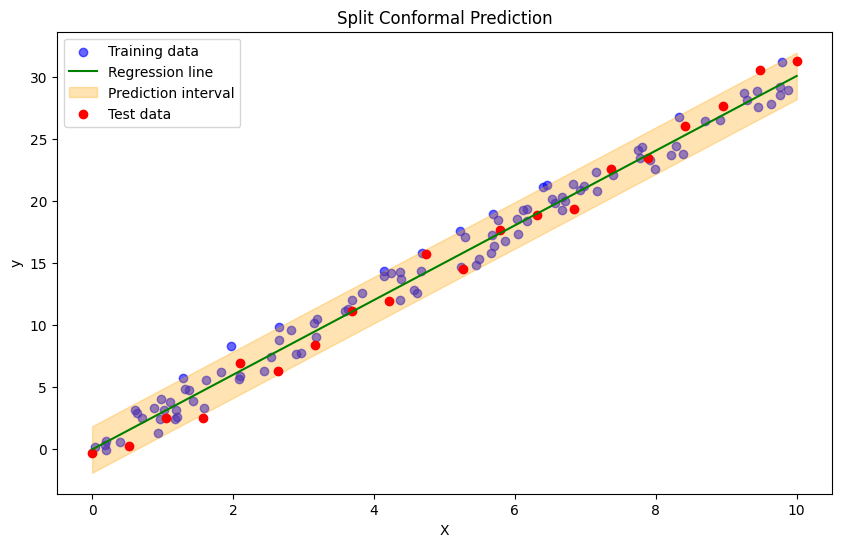

In [27]:
# splitted the data into D1 and D2
def split_conformal_prediction(X, y, alpha=0.1, random_state=42):
    # Split data into D1 (training) and D2 (calibration)
    X_train, X_calib, y_train, y_calib = train_test_split(
        X, y, test_size=0.5, random_state=random_state
    )

    # fitted regression model h on D1
    model = LinearRegression()
    model.fit(X_train, y_train)

    # computed residuals on D2
    y_calib_pred = model.predict(X_calib)
    residuals = np.abs(y_calib - y_calib_pred)

    # computed the alpha-quantile (q_alpha) of the residuals
    q_alpha = np.quantile(residuals, 1 - alpha)

    # constructed prediction interval C(x) for new data
    def prediction_interval(x):
        pred = model.predict(x.reshape(1, -1))[0]
        return pred - q_alpha, pred + q_alpha

    return model, prediction_interval, q_alpha

# I generated synthetic data for an example
np.random.seed(0)
X = np.random.rand(100, 1) * 10  # Features
y = 3 * X.squeeze() + np.random.normal(0, 1, size=100)  # Target with noise

# applied conformal prediction
alpha = 0.1  # Confidence level (90% prediction intervals)
model, prediction_interval, q_alpha = split_conformal_prediction(X, y, alpha=alpha)

# testing the prediction intervals
X_test = np.linspace(0, 10, 20).reshape(-1, 1)  # Test points
y_test = 3 * X_test.squeeze() + np.random.normal(0, 1, size=20)

# computed prediction intervals for the test set
intervals = np.array([prediction_interval(x) for x in X_test])

# plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(X, y, label="Training data", color="blue", alpha=0.6)
plt.plot(X_test, model.predict(X_test), label="Regression line", color="green")
plt.fill_between(
    X_test.squeeze(),
    intervals[:, 0],
    intervals[:, 1],
    color="orange",
    alpha=0.3,
    label="Prediction interval"
)
plt.scatter(X_test, y_test, label="Test data", color="red")
plt.title("Split Conformal Prediction")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

# Output:

# Model's prediction intervals and visualization


The code implements a method to define prediction intervals using a linear regression model. First, the dataset is split into two parts: D1, which is used to train the regression model, and D2, which is used to compute residuals. The model is trained on D1, and absolute residuals (differences between actual and predicted values) are calculated for D2. The alpha-quantile of these residuals is then determined, which defines the width of the prediction interval. Finally, for a new input, the prediction interval is calculated as \([h(x) - q, h(x) + q]\), where \(q\) is the computed quantile.

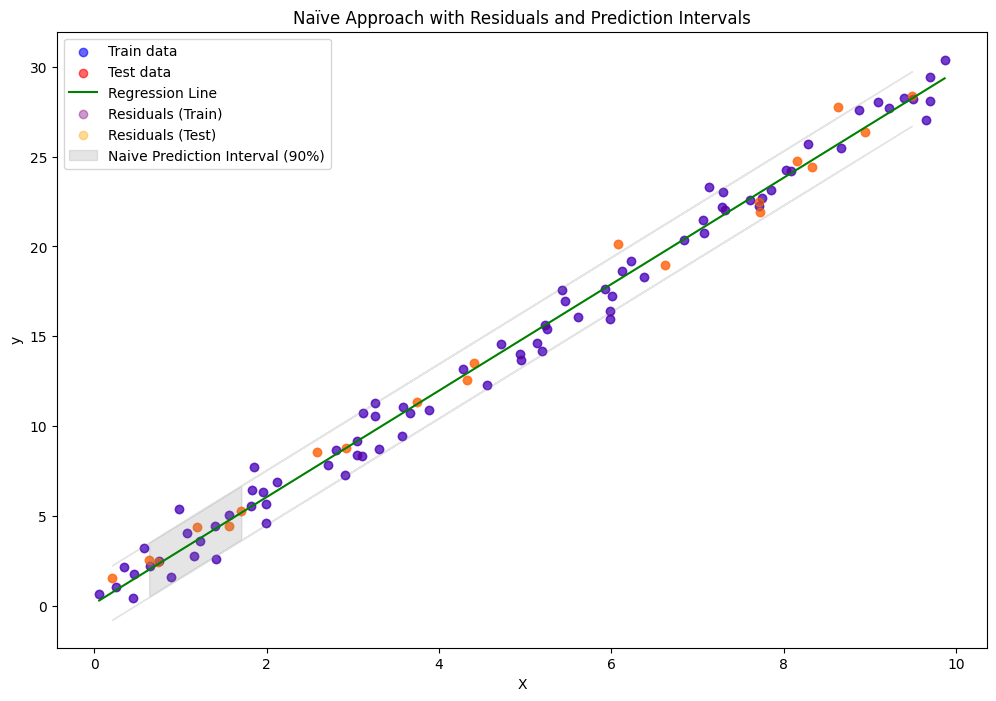

In [29]:
#In this case I applied naive approach

# Generate synthetic data
np.random.seed(42)
X = np.random.rand(100, 1) * 10  # Features
y = 3 * X.squeeze() + np.random.normal(0, 1, size=100)  # Target with Gaussian noise

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Compute residuals
residuals_train = y_train - y_train_pred
residuals_test = y_test - y_test_pred

# Calculate Gaussian noise assumption (mean and std dev of residuals)
mu, sigma = np.mean(residuals_train), np.std(residuals_train)

# Naïve prediction intervals assuming Gaussian residuals
def naive_prediction_interval(x, mu, sigma, confidence=0.9):
    z = 1.645  # For 90% confidence interval
    pred = model.predict(x.reshape(1, -1))[0]
    return pred - z * sigma, pred + z * sigma

# Compute prediction intervals for the test set
intervals_naive = np.array([naive_prediction_interval(x, mu, sigma) for x in X_test])

# Plot results
plt.figure(figsize=(12, 8))

# Scatter plot for train and test data
plt.scatter(X_train, y_train, label="Train data", color="blue", alpha=0.6)
plt.scatter(X_test, y_test, label="Test data", color="red", alpha=0.6)

# Regression line
X_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
plt.plot(X_line, model.predict(X_line), label="Regression Line", color="green")

# Plot residuals for train and test data
plt.scatter(X_train, residuals_train + y_train_pred, color="purple", alpha=0.4, label="Residuals (Train)")
plt.scatter(X_test, residuals_test + y_test_pred, color="orange", alpha=0.4, label="Residuals (Test)")

# Prediction intervals
plt.fill_between(
    X_test.squeeze(),
    intervals_naive[:, 0],
    intervals_naive[:, 1],
    color="gray",
    alpha=0.2,
    label="Naive Prediction Interval (90%)",
)

# Formatting plot
plt.title("Naïve Approach with Residuals and Prediction Intervals")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


omment on the Results:
The shaded region, representing the naïve prediction interval, lies inside the predicted range because the interval is constructed based on the Gaussian noise assumption of residuals. The assumption is that the residuals (errors between actual and predicted values) follow a normal distribution centered around the regression line, with a standard deviation (sigma) estimated from the training data. This provides a symmetric confidence interval around the predicted values, ensuring that most data points—both training and test—fall within the interval.

The majority of the test and training data points lie within the interval because the prediction interval is designed to capture approximately 90% of the data ((1 - alpha)) under the Gaussian assumption. This behavior is expected in well-behaved data, where the underlying noise closely adheres to the normal distribution assumption.
Deviations from this pattern could indicate issues such as:Outliers in the data, non-Gaussian noise (e.g., skewed, bimodal), model misfit or heteroscedasticity (varying noise levels).

However, the observed conformity suggests that the model and the assumptions made are reasonable for the dataset used.

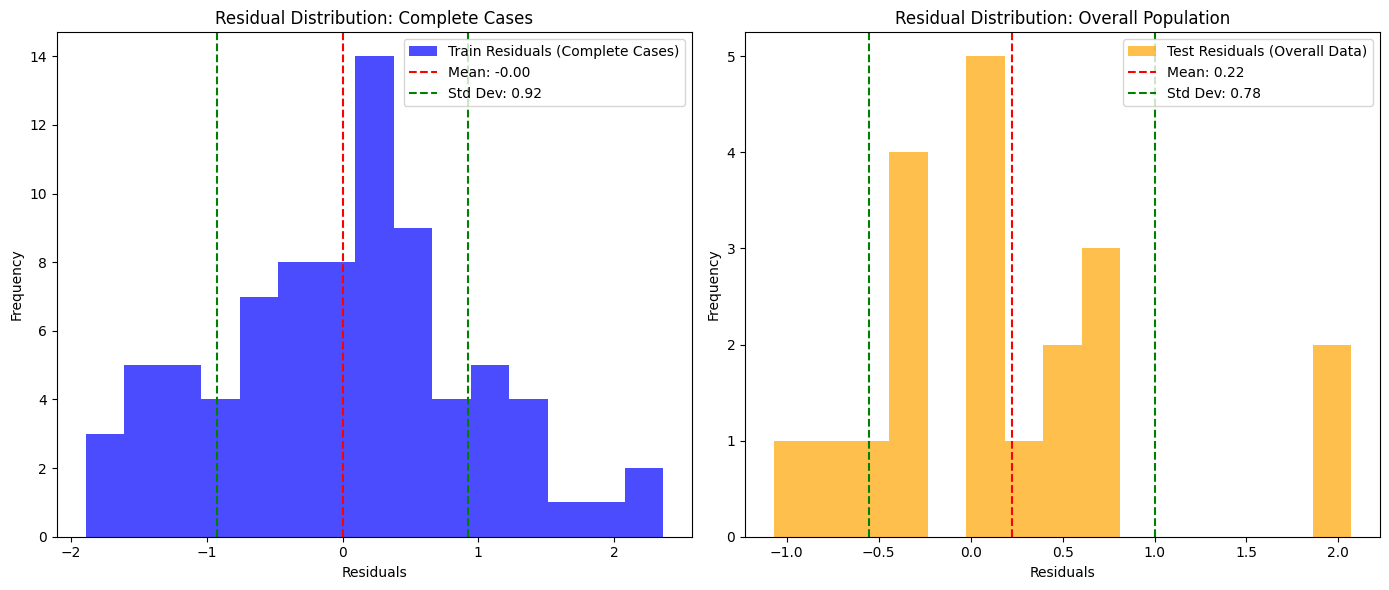

In [30]:
# Intepretation: plotting the histogram of residuals

# Plot residual histograms for complete and overall data
plt.figure(figsize=(14, 6))

# Training residuals (complete cases)
plt.subplot(1, 2, 1)
plt.hist(residuals_train, bins=15, color="blue", alpha=0.7, label="Train Residuals (Complete Cases)")
plt.axvline(residuals_train.mean(), color="red", linestyle="--", label=f"Mean: {residuals_train.mean():.2f}")
plt.axvline(residuals_train.mean() + residuals_train.std(), color="green", linestyle="--", label=f"Std Dev: {residuals_train.std():.2f}")
plt.axvline(residuals_train.mean() - residuals_train.std(), color="green", linestyle="--")
plt.title("Residual Distribution: Complete Cases")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()

# Test residuals (overall data)
plt.subplot(1, 2, 2)
plt.hist(residuals_test, bins=15, color="orange", alpha=0.7, label="Test Residuals (Overall Data)")
plt.axvline(residuals_test.mean(), color="red", linestyle="--", label=f"Mean: {residuals_test.mean():.2f}")
plt.axvline(residuals_test.mean() + residuals_test.std(), color="green", linestyle="--", label=f"Std Dev: {residuals_test.std():.2f}")
plt.axvline(residuals_test.mean() - residuals_test.std(), color="green", linestyle="--")
plt.title("Residual Distribution: Overall Population")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()


The visualizations compare the residual distributions of the training set (complete cases) and the test set (overall population). In the left histogram, the training residuals exhibit a relatively symmetric distribution centered around zero, with a mean close to zero (-0.00) and a standard deviation of 0.92, suggesting that the regression model fits the training data well. However, in the right histogram, the test residuals show a less symmetric pattern and a slight positive mean (0.22), indicating a potential bias in the model's predictions for the test set. Additionally, the lower standard deviation of the test residuals (0.78) suggests that the model might generalize less effectively, potentially underestimating variability in unseen data. These differences highlight the importance of further evaluating the model's robustness and ensuring it performs consistently across diverse data distributions.